# Killer Demo: Compute a global mean, annual mean timeseries from the CESM Large Ensemble

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import math, time
from dask.distributed import Client, wait
import ncar_jobqueue
import dask
import xarray as xr
import intake
import numpy as np
from distributed.utils import format_bytes 
import matplotlib.pyplot as plt
import esmlab

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Spin up a dask cluster
We are using `ncar_jobqueue.NCARCluster`; this just passes thru to `dask_jobqueue.PBSCluster` or `dask_jobqueue.SLURMCluster` depending on whether you are on Cheyenne or a DAV machine.

Note: `dask_jobqueue.SLURMCluster` does not work on Cheyenne compute nodes, though the cluster jobs will start giving the appearance of functionality.

Default arguments to `ncar_jobqueue.NCARCluster` are set in `~/.config/dask/jobqueue.yaml`; you can over-ride these defaults by passing in arguments directly here.

In [3]:
cluster = ncar_jobqueue.NCARCluster(walltime="01:00:00", cores=36, memory='370GB', processes=3, project='NTDD0005')
client = dask.distributed.Client(cluster)
n_workers = 3 * 15
cluster.scale(n_workers)

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:106: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [5]:
client

<Client: scheduler='tcp://10.12.205.19:34587' processes=42 cores=504>

## Connect to the intake-esm data catalog

An input file `cesm1-le-collection.yml` specifies where to look for files and assembles a database for the CESM-LE. `intake-esm` configuration settings are stored by default in `~/.intake_esm/config.yaml` or locally in `.intake_esm/config.yaml`. Key things to specify are the `database_directory`, which is where the catalog data file (csv) is written to disk.

In [6]:
col = intake.open_esm_metadatastore(collection_input_definition='cesm1-le-collection.yml', 
                                    overwrite_existing=False)
col.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116280 entries, 0 to 116279
Data columns (total 18 columns):
resource            116280 non-null object
resource_type       116280 non-null object
direct_access       116280 non-null bool
experiment          116280 non-null object
case                116280 non-null object
component           116280 non-null object
stream              116280 non-null object
variable            116280 non-null object
date_range          116280 non-null object
ensemble            116280 non-null int64
file_fullpath       116280 non-null object
file_basename       116280 non-null object
file_dirname        116280 non-null object
ctrl_branch_year    0 non-null float64
year_offset         15145 non-null float64
sequence_order      116280 non-null int64
has_ocean_bgc       116280 non-null bool
grid                13013 non-null object
dtypes: bool(2), float64(2), int64(2), object(12)
memory usage: 15.3+ MB


## Compute grid weights for a global mean

### Load a dataset and read in the grid variables

To compute a properly-weighted spatial mean, we need a cell-volume array. We'll pick out the necessary grid variables from a single file. First, let's get an arbitrary POP history file from the catalog.

In [7]:
arbitrary_pop_file = col.search(experiment='20C', stream='pop.h').query_results.file_fullpath.tolist()[0]
ds = xr.open_dataset(arbitrary_pop_file, decode_times=False, decode_coords=False)
grid_vars = ['KMT', 'z_t', 'TAREA', 'dz']
ds = ds.drop([v for v in ds.variables if v not in grid_vars]).compute()
ds

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    dz       (z_t) float32 1000.0 1000.0 1000.0 ... 24992.674 24996.244 24998.11
Attributes:
    title:                     b.e11.B20TRC5CNBDRD.f09_g16.001
    history:                   Fri Aug 30 23:36:34 2013: /glade/apps/opt/nco/...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    calendar:                  All years have exactly  365 days.
    start_time:                Th

### Compute a 3D topography mask

Now we'll compute the 3D volume field, masked appropriate by the topography.

First step is to create the land mask.

Text(0.5, 1.0, 'Pacific transect')

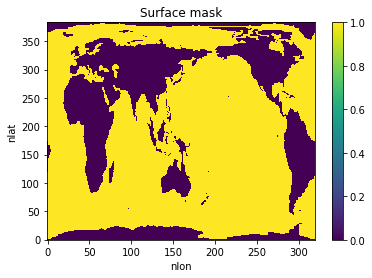

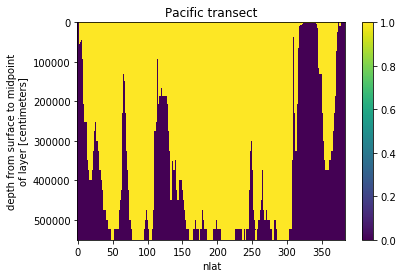

In [8]:
nk = len(ds.z_t)
nj = ds.KMT.shape[0]
ni = ds.KMT.shape[1]

# make 3D array of 0:km
k_vector_one_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'), coords={'z_t': ds.z_t})
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'), coords={'z_t': ds.z_t})
MASK = (k_vector_one_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = MASK.where(MASK <= ds.KMT - 1)
MASK = xr.where(MASK.notnull(), 1., 0.)

plt.figure()
MASK.isel(z_t=0).plot()
plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=200).plot(yincrease=False)
plt.title('Pacific transect')

### Compute the 3D volume field
Now we'll compute the masked volume field by multiplying `z_t` by `TAREA` by the mask created above.

Text(0.5, 1.0, 'Pacific transect')

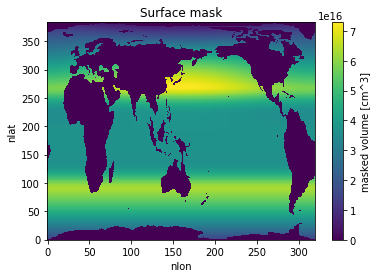

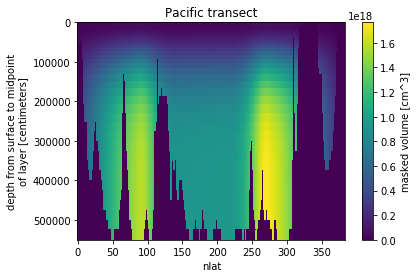

In [9]:
MASKED_VOL = ds.dz * ds.TAREA * MASK
MASKED_VOL.attrs['units'] = 'cm^3'
MASKED_VOL.attrs['long_name'] = 'masked volume'
plt.figure()
MASKED_VOL.isel(z_t=0).plot()
plt.title('Surface mask')

plt.figure()
MASKED_VOL.isel(nlon=200).plot(yincrease=False)
plt.title('Pacific transect')

## Compute global-mean, annual-means across the ensemble

### Find the ensemble members that have ocean biogeochemistry
(several of the runs had corrupted BGC fields)

In [10]:
member_ids = col.search(experiment=['20C', 'RCP85'], has_ocean_bgc=True).query_results.ensemble.unique().tolist()
print(member_ids)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 35, 101, 102, 103, 104, 105]


### Load data into an xarray dataset

We'll query intake-esm to get a subset of the catalog that contains data sets of interest.

In [11]:
variable = ['O2']
query = dict(ensemble=member_ids, experiment=['20C', 'RCP85'], 
                 stream='pop.h', variable=variable, direct_access=True)
col_subset = col.search(**query)
col_subset.query_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 100509 to 292
Data columns (total 18 columns):
resource            89 non-null object
resource_type       89 non-null object
direct_access       89 non-null bool
experiment          89 non-null object
case                89 non-null object
component           89 non-null object
stream              89 non-null object
variable            89 non-null object
date_range          89 non-null object
ensemble            89 non-null int64
file_fullpath       89 non-null object
file_basename       89 non-null object
file_dirname        89 non-null object
ctrl_branch_year    0 non-null float64
year_offset         0 non-null float64
sequence_order      89 non-null int64
has_ocean_bgc       89 non-null bool
grid                89 non-null object
dtypes: bool(2), float64(2), int64(2), object(12)
memory usage: 12.0+ KB


Once the query is executed, we'll use the `to_xarray()` method to let intake-esm know that we want it to load the data into an xarray dataset. 
Ensembles will be concatenated along a new dimension `member_id`:

In [12]:
chunks= {'time': 24, 'z_t': 30}

In [13]:
%%time 
ds = col_subset.to_xarray(chunks=chunks, decode_times=False, decode_coords=False)


CPU times: user 6.08 s, sys: 442 ms, total: 6.52 s
Wall time: 36.3 s


In [14]:
format_bytes(ds.nbytes)

'2.84 TB'

In [15]:
ds

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 32, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 3012, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * time                  (time) float64 6.753e+05 6.753e+05 ... 7.669e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
  * member_id             (member_id) int64 1 2 9 10 11 ... 101 102 103 104 105
Dimensions without coordinates: d2, moc_comp, nlat, nl

### Compute Annual mean

In [16]:
%time global_mean = esmlab.resample(ds, freq='ann', time_coord_name='time')

CPU times: user 7.42 s, sys: 338 ms, total: 7.76 s
Wall time: 7.73 s


In [17]:
%%time
global_mean = global_mean.persist()
wait(global_mean)

CPU times: user 6min 36s, sys: 26.5 s, total: 7min 2s
Wall time: 16min 45s


In [18]:
format_bytes(global_mean.nbytes)

'473.77 GB'

In [19]:
global_mean

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 32, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 251, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * member_id             (member_id) int64 1 2 9 10 11 ... 101 102 103 104 105
  * z_t                   (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * time                  (time) float64 6.754e+05 6.758e+05 ... 7.667e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: d2, moc_comp, nlat, 

### Compute Weighted Global Mean

In [20]:
%%time 
global_mean = esmlab.statistics.weighted_mean(global_mean, 
                                                  weights=MASKED_VOL, 
                                                  dim=['z_t', 'nlat', 'nlon'])

CPU times: user 553 ms, sys: 35.9 ms, total: 589 ms
Wall time: 553 ms


In [21]:
format_bytes(global_mean.nbytes)

'20.72 MB'

In [22]:
%%time
computed_mean = global_mean.compute()

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/worker.py:2827: UserWarning: Large object of size 58.98 MB detected in task graph: 
  (array([[[[[0.00000000e+00, 0.00000000e+00, 0.0000 ... 0, 320, None)))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


CPU times: user 40.8 s, sys: 2.51 s, total: 43.3 s
Wall time: 47.7 s


In [23]:
computed_mean

<xarray.Dataset>
Dimensions:               (d2: 2, member_id: 32, moc_comp: 3, nlat: 384, nlon: 320, time: 251, transport_comp: 5, transport_reg: 2, z_t: 60, z_w: 60)
Coordinates:
  * time                  (time) float64 6.754e+05 6.758e+05 ... 7.667e+05
  * member_id             (member_id) int64 1 2 9 10 11 ... 101 102 103 104 105
  * z_t                   (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    time_bound            (d2, time) float64 6.753e+05 6.756e+05 ... 7.669e+05
    O2                    (member_id, time) float64 177.6 177.6 ... 169.8 169.7
    ANGLE                 (nlat, nlon) float64 0.0 0.0 0.0 ... -0.0259 2.804e-07
    ANGLET                (nlat, nlon) float64 0.0 0.0 0.0 ... -0.03805 -0.01268
    DXT                   (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06


In [24]:
%load_ext watermark
%watermark --iversion -g -m -v -u -d -h

intake        0.4.4
ncar_jobqueue v2019.3.8
esmlab        v2019.3.16+140.gd3ce9a5
matplotlib    3.0.3
dask          1.2.0
xarray        0.12.1
numpy         1.15.4
last updated: 2019-04-16 

CPython 3.7.3
IPython 7.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper10
Git hash   : d3ce9a523a8ea8776b5b46fa6835472a1728b8d4
